# Implementing your own events

Although the events we provide in this package are relatively limited, CBMOS is designed to be flexible enough to use any event you wish to implement.

New event can easily be implemented by deriving the abstract `Event` class and overriding the `__init__` and `apply` methods. As mentionned in `Event` class' documentation, the only requirement is that the new subclass possesses an attribute `tau`, which represents the time at which the event is triggered. The `apply` method takes an object of type `CBModel` as unique parameter. This object contains all the information about the current simulation and can be used to add, modify and remove cells.

In this example, we implement two simple events:

- `GlobalDeathEvent` selects one cell at random and removes it from the simulation.
- `GlobalDivisionEvent` selects one cell at random and duplicates it.

Here, we set the simulation so that these events are triggered at regular intervals. This mimics other cell-based software, where the simulation is stopped at regular intervals to check if events have taken place.

Although cell division and cell death can be implemented in many different ways, depending of the complexity of the biological model. We hope these examples illustrate how CBMOS can handle such a variety of possibilities.

In [1]:
import numpy as np
import numpy.random as npr

npr.seed(0)

from cbmos.events import Event
from cbmos.cell import Cell

class GlobalDeathEvent(Event):
    def __init__(self, tau):
        self.tau = tau
        
    def apply(self, cbmodel):
        target_cell = npr.choice(cbmodel.cell_list)
        del cbmodel.cell_list[npr.randint(len(cbmodel.cell_list))]

class GlobalDivisionEvent(Event):
    def __init__(self, tau):
        self.tau = tau
        
    def apply(self, cbmodel):
        target_cell = npr.choice(cbmodel.cell_list)
        
        division_direction = self.get_division_direction(cbmodel)
        updated_position_parent = target_cell.position \
            - 0.5 * cbmodel.separation * division_direction
        position_daughter = target_cell.position \
            + 0.5 * cbmodel.separation * division_direction

        daughter_cell = Cell(cbmodel.next_cell_index, position_daughter)
        cbmodel.next_cell_index += 1
        cbmodel.cell_list.append(daughter_cell)

        target_cell.position = updated_position_parent

    def get_division_direction(self, cbmodel):
        if cbmodel.dim == 1:
            division_direction = np.array([-1.0 + 2.0 * npr.randint(2)])

        elif cbmodel.dim == 2:
            random_angle = 2.0 * np.pi * npr.rand()
            division_direction = np.array([
                np.cos(random_angle),
                np.sin(random_angle)])

        elif cbmodel.dim == 3:
            u = npr.rand()
            v = npr.rand()
            random_azimuth_angle = 2 * np.pi * u
            random_zenith_angle = np.arccos(2 * v - 1)
            division_direction = np.array([
                np.cos(random_azimuth_angle) * np.sin(random_zenith_angle),
                np.sin(random_azimuth_angle) * np.sin(random_zenith_angle),
                np.cos(random_zenith_angle)])

        return division_direction

In [2]:
import numpy as np

import cbmos.cell as cl
import cbmos.utils as utils

T = 4
t_data = np.linspace(0, T, num=6)

n_x = 5
n_y = 5
coordinates = utils.generate_cartesian_coordinates(n_x, n_y)

sheet = [
    cl.Cell(
        i, # Cell ID, must be unique to each cell
        [x,y], # Initial coordinates
    )
    for i, (x, y) in enumerate(coordinates)
]

event_list = [
    GlobalDivisionEvent(tau)
    for tau in np.linspace(0, T, num=50)
] + [
    GlobalDeathEvent(tau)
    for tau in np.linspace(0, T, num=25)
]


In [3]:
import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef

# Initialize model
model = cbmos.CBModel(ff.Gls(), ef.solve_ivp, dimension=2)

In [4]:
t_data, history = model.simulate(
    sheet, # Initial cell configuration
    t_data, # Times at which the history is saved
    {"mu": 5.70, "s": 1.0, "rA": 1.5}, # Force parameters
    {'dt': 0.01}, # Solver parameters
    event_list=event_list,
    raw_t=False,
)

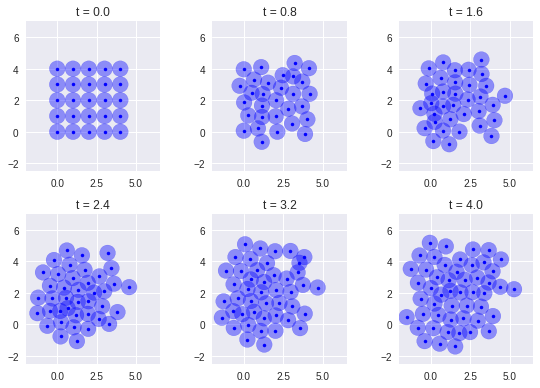

In [5]:
import matplotlib.pyplot as plt

color = 'blue'

fig, ax = plt.subplots(2, 3)
for i, cells in enumerate(history):
    for cell in cells:
        ax[i//3, i%3].add_patch(plt.Circle(cell.position, 0.5, color=color, alpha=0.4))
        ax[i//3, i%3].plot(cell.position[0], cell.position[1], '.', color=color)
        ax[i//3, i%3].set_aspect('equal')
        ax[i//3, i%3].set_xlim(-2, 6.5)
        ax[i//3, i%3].set_ylim(-2.5, 7)
        ax[i//3, i%3].set_title(f"t = {t_data[i]:.1f}")

fig.tight_layout()